In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/AUA/AUA 2020 Spring/Deep Learning/DL_HW4')

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from testCases_Pytorch import *
from opt_utils_v1a_Pytorch import initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a_Pytorch import compute_cost, predict, predict_dec, plot_decision_boundary_2D


%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision = 8)

# 1. Graadient Descent

In [0]:
def update_parameters_with_gd(parameters, grads, learning_rate):

    L = len(parameters) // 2 # number of layers in the neural networks

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

In [0]:
params, grads, learning_rate = update_parameters_with_gd_test_case()

parameters = update_parameters_with_gd(params, grads, learning_rate)
print("W1 =\n" + str(parameters["W1"]))
print("b1 =\n" + str(parameters["b1"]))
print("W2 =\n" + str(parameters["W2"]))
print("b2 =\n" + str(parameters["b2"]))

W1 =
tensor([[ 1.63535156, -0.62320365, -0.53718766],
        [-1.07799357,  0.85639907, -2.29470142]])
b1 =
tensor([[ 1.74604067],
        [-0.75184921]])
W2 =
tensor([[ 0.32171798, -0.25467393,  1.46902454],
        [-2.05617317, -0.31554548, -0.37560230],
        [ 1.14048190, -1.09976462, -0.16125510]])
b2 =
tensor([[-0.88020257],
        [ 0.02561572],
        [ 0.57539477]])


# 2. Mini-Batch Gradient Descent

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
   
    np.random.seed(seed)           
    m = X.shape[1]                 
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

  
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k + 1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: torch.Size([12288, 64])
shape of the 2nd mini_batch_X: torch.Size([12288, 64])
shape of the 3rd mini_batch_X: torch.Size([12288, 20])
shape of the 1st mini_batch_Y: torch.Size([1, 64])
shape of the 2nd mini_batch_Y: torch.Size([1, 64])
shape of the 3rd mini_batch_Y: torch.Size([1, 20])
mini batch sanity check: tensor([ 0.90085595, -0.76120690,  0.23441570])


# 3. Momentum

In [0]:
def initialize_velocity(parameters):

    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initializing velocity
    for l in range(L):
        v["dW" + str(l+1)] = torch.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l+1)] = torch.zeros_like(parameters["b" + str(l+1)])
        
    return v

In [0]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] =\n" + str(v["dW1"]))
print("v[\"db1\"] =\n" + str(v["db1"]))
print("v[\"dW2\"] =\n" + str(v["dW2"]))
print("v[\"db2\"] =\n" + str(v["db2"]))

v["dW1"] =
tensor([[0., 0., 0.],
        [0., 0., 0.]])
v["db1"] =
tensor([[0.],
        [0.]])
v["dW2"] =
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
v["db2"] =
tensor([[0.],
        [0.],
        [0.]])


In [0]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
  
    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
        v["dW" + str(l+1)] =  beta * v["dW" + str(l + 1)] + (1 - beta) * grads['dW' + str(l + 1)]
        v["db" + str(l+1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads['db' + str(l + 1)] 
        # updatng parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]
        
    return parameters, v

In [0]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = v" + str(v["db2"]))

W1 = 
tensor([[ 1.62544598, -0.61290114, -0.52907334],
        [-1.07347112,  0.86450677, -2.30085497]])
b1 = 
tensor([[ 1.74493465],
        [-0.76027113]])
W2 = 
tensor([[ 0.31930698, -0.24990073,  1.46279960],
        [-2.05974396, -0.32173003, -0.38320915],
        [ 1.13444069, -1.09987860, -0.17131090]])
b2 = 
tensor([[-0.87809283],
        [ 0.04055394],
        [ 0.58207317]])
v["dW1"] = 
tensor([[-0.11006192,  0.11447237,  0.09015907],
        [ 0.05024943,  0.09008559, -0.06837279]])
v["db1"] = 
tensor([[-0.01228902],
        [-0.09357694]])
v["dW2"] = 
tensor([[-0.02678881,  0.05303555, -0.06916608],
        [-0.03967535, -0.06871727, -0.08452056],
        [-0.06712461, -0.00126646, -0.11173103]])
v["db2"] = vtensor([[0.02344157],
        [0.16598022],
        [0.07420442]])


# 4. Adam

In [0]:
def initialize_adam(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. .
    for l in range(L):
        v["dW" + str(l+1)] = torch.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l+1)] = torch.zeros_like(parameters["b" + str(l + 1)])
        s["dW" + str(l+1)] = torch.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l+1)] = torch.zeros_like(parameters["b" + str(l + 1)])
    
    return v, s

In [0]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

v["dW1"] = 
tensor([[0., 0., 0.],
        [0., 0., 0.]])
v["db1"] = 
tensor([[0.],
        [0.]])
v["dW2"] = 
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
v["db2"] = 
tensor([[0.],
        [0.],
        [0.]])
s["dW1"] = 
tensor([[0., 0., 0.],
        [0., 0., 0.]])
s["db1"] = 
tensor([[0.],
        [0.]])
s["dW2"] = 
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
s["db2"] = 
tensor([[0.],
        [0.],
        [0.]])


In [0]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
  
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    for l in range(L):
        # Moving average of the gradients. 
        v["dW" + str(l+1)] =  beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]
      

        # Compute bias-corrected first moment estimate.
        v_corrected["dW" + str(l+1)] = v["dW" + str(l + 1)] / (1 - pow(beta1, t))
        v_corrected["db" + str(l+1)] = v["db" + str(l + 1)] / (1 - pow(beta1, t))
      

        # Moving average of the squared gradients. 
        s["dW" + str(l+1)] =  beta2 * s["dW" + str(l + 1)] + (1 - beta2) * pow(grads['dW' + str(l + 1)], 2)
        s["db" + str(l+1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * pow(grads['db' + str(l + 1)], 2) 
      

        # Compute bias-corrected second raw moment estimate. 
        s_corrected["dW" + str(l+1)] = s["dW" + str(l + 1)] / (1 - pow(beta2, t))
        s_corrected["db" + str(l+1)] = s["db" + str(l + 1)] / (1 - pow(beta2, t))
      

        # Update parameters. Inputs: 
        parameters["W" + str(l+1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / torch.sqrt(s_corrected["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / torch.sqrt(s_corrected["db" + str(l + 1)] + epsilon)
      

    return parameters, v, s

In [0]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

W1 = 
tensor([[ 1.63178673, -0.61919778, -0.53561312],
        [-1.08040999,  0.85796626, -2.29409733]])
b1 = 
tensor([[ 1.75225313],
        [-0.75376553]])
W2 = 
tensor([[ 0.32648046, -0.25681174,  1.46954931],
        [-2.05269934, -0.31497584, -0.37661299],
        [ 1.14121081, -1.09245036, -0.16498684]])
b2 = 
tensor([[-0.88529978],
        [ 0.03477238],
        [ 0.57537385]])
v["dW1"] = 
tensor([[-0.11006192,  0.11447237,  0.09015907],
        [ 0.05024943,  0.09008559, -0.06837279]])
v["db1"] = 
tensor([[-0.01228902],
        [-0.09357694]])
v["dW2"] = 
tensor([[-0.02678881,  0.05303555, -0.06916608],
        [-0.03967535, -0.06871727, -0.08452056],
        [-0.06712461, -0.00126646, -0.11173103]])
v["db2"] = 
tensor([[0.02344157],
        [0.16598022],
        [0.07420442]])
s["dW1"] = 
tensor([[0.00121136, 0.00131039, 0.00081287],
        [0.00025250, 0.00081154, 0.00046748]])
s["db1"] = 
tensor([[1.51020075e-05],
        [8.75664434e-04]])
s["dW2"] = 
tensor([[7.17640232e-

# 5 - Model with different optimization algorithms

In [0]:
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualizing the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))

    train_X = torch.from_numpy(train_X)
    train_Y = torch.from_numpy(train_Y)
    
    return train_X, train_Y

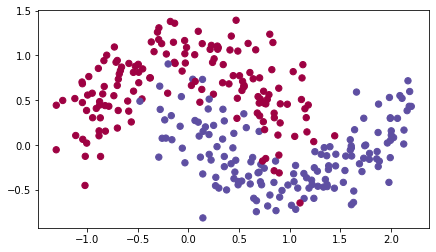

In [0]:
train_X, train_Y = load_dataset()

In [0]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # I increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

## 5.1 - Mini-batch Gradient descent

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367
Cost after epoch 5000: 0.551977
Cost after epoch 6000: 0.532370
Cost after epoch 7000: 0.514007
Cost after epoch 8000: 0.496472
Cost after epoch 9000: 0.468014


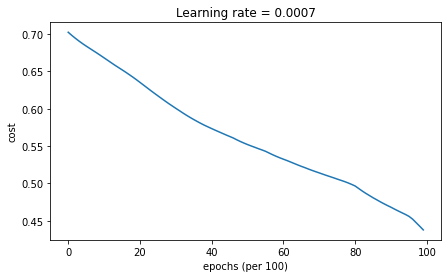

Accuracy: tensor(0.79666667)


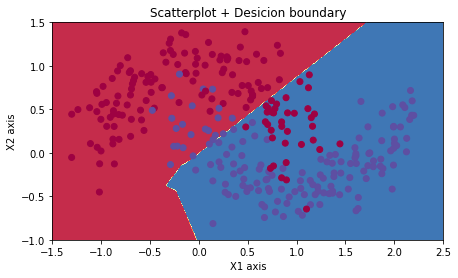

In [0]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary_2D(lambda x: predict_dec(parameters, x), train_X, train_Y)

## 5.2 - Mini-batch gradient descent with momentum

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444
Cost after epoch 5000: 0.552058
Cost after epoch 6000: 0.532458
Cost after epoch 7000: 0.514101
Cost after epoch 8000: 0.496652
Cost after epoch 9000: 0.468160


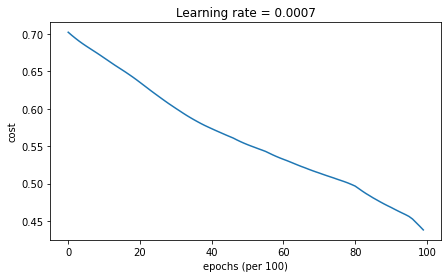

Accuracy: tensor(0.79666667)


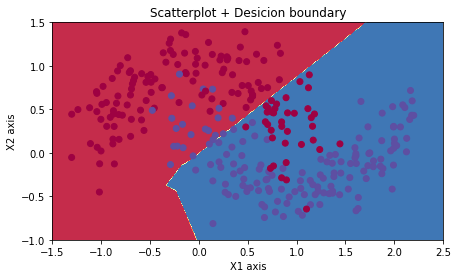

In [0]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary_2D(lambda x: predict_dec(parameters, x), train_X, train_Y)

Cost after epoch 0: 0.702166
Cost after epoch 1000: 0.167966
Cost after epoch 2000: 0.141320
Cost after epoch 3000: 0.138782
Cost after epoch 4000: 0.136111
Cost after epoch 5000: 0.134327
Cost after epoch 6000: 0.131147
Cost after epoch 7000: 0.130245
Cost after epoch 8000: 0.129655
Cost after epoch 9000: 0.129159


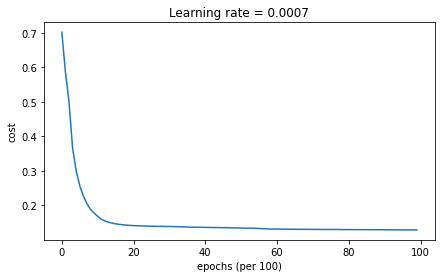

Accuracy: tensor(0.94000000)


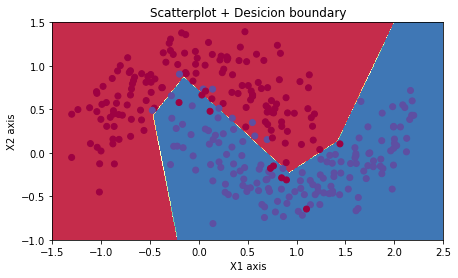

In [0]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary_2D(lambda x: predict_dec(parameters, x), train_X, train_Y)

## 5.3 - Mini-batch with Adam mode

### 5.4 - Summary

<table> 
  <tr>
      <td>
      **optimization method**
      </td>
      <td>
      **accuracy**
      </td>
      <td>
      **cost shape**
      </td>

  </tr>
      <td>
      Gradient descent
      </td>
      <td>
      79.7%
      </td>
      <td>
      oscillations
      </td>
  <tr>
      <td>
      Momentum
      </td>
      <td>
      79.7%
      </td>
      <td>
      oscillations
      </td>
  </tr>
  <tr>
      <td>
      Adam
      </td>
      <td>
      94%
      </td>
      <td>
      smoother
      </td>
  </tr>
</table> 

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligeable. Also, the huge oscillations you see in the cost come from the fact that some minibatches are more difficult thans others for the optimization algorithm.

Adam on the other hand, clearly outperforms mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:
- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)